# Select the first n physical and chemical properties from 531 physical and chemical properties as the coding scheme

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from numpy import *
import re, os, sys
from collections import Counter
from tqdm import tqdm
from scipy import stats

In [2]:
parent_dir = os.path.abspath(os.path.dirname(os.getcwd()))

In [81]:
AA = 'ARNDCQEGHILKMFPSTWYV'
fileAAindex = os.path.join(parent_dir, r'Data\AAindex.txt') # data file
with open(fileAAindex) as f:
    records = f.readlines()[1:]
AAindex = []
AAindexName = []
for i in records:
    AAindex.append(i.rstrip().split()[1:] if i.rstrip() != '' else None)
    AAindexName.append(i.rstrip().split()[0] if i.rstrip() != '' else None)

In [4]:
trainfilepath = os.path.join(parent_dir, r'Data\five_fold_cross_validation.csv')
testfilepath = os.path.join(parent_dir, r'Data\independent.csv')

In [37]:
def get_mean_auc(data, label_column=0, score_column=2):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for i in range(len(data)):
        fpr, tpr, thresholds = roc_curve(data[i][:, label_column], data[i][:, score_column])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    return mean_auc, aucs

In [38]:
def single_AAindex_encoding(filepath,name):
    encodings = []
    dataframe = pd.read_csv(filepath)
    label = list(dataframe['Label'])
    sequences = list(dataframe['Sequence'])
    for i in sequences:
        sequence = re.sub('[^ACDEFGHIKLMNPQRSTVWYX]', 'X', ''.join(i).upper())
        code = []
        for j in sequence:
            if j in AA:
                value = AAindex[AAindexName.index(name)][AA.index(j)]
            else:
                value = 0
            code.append(value)
        encodings.append(code)
    return np.array(encodings).astype(np.float64), np.array(label).astype(np.float64)

In [39]:
def AAindex_encoding(filepath,select_name):
    encodings = []
    dataframe = pd.read_csv(filepath)
    label = list(dataframe['Label'])
    sequences = list(dataframe['Sequence'])
    for i in sequences:
        sequence = re.sub('[^ACDEFGHIKLMNPQRSTVWYX]', 'X', ''.join(i).upper())
        code = []
        for j in sequence:
            for k in select_name:
                if j in AA:
                    value = AAindex[AAindexName.index(k)][AA.index(j)]
                else:
                    value = 0
                code.append(value)
        encodings.append(code)
    return np.array(encodings).astype(np.float64), np.array(label).astype(np.float64)

### First calculate the AUC performance of a single physical and chemical property, a total of 531 groups of AUC values

In [19]:
aaindex = {}
categories = [0, 1]
for name in tqdm(AAindexName):
    X, y = single_AAindex_encoding(trainfilepath, name)
    x_test, y_test = single_AAindex_encoding(testfilepath, name)
    folds = StratifiedKFold(5).split(X, y)
    prediction_result_ind = []
    for i, (train, valid) in enumerate(folds):
        train_X, train_y = X[train], y[train]
        valid_X, valid_y = X[valid], y[valid]
        rfc_model = RandomForestClassifier(n_estimators=350, bootstrap=True, oob_score=True, n_jobs=6)
        rfc = rfc_model.fit(train_X, train_y)

        tmp_result = np.zeros((len(y_test), len(categories) + 1))
        tmp_result[:, 0], tmp_result[:, 1:] = y_test, rfc.predict_proba(x_test)
        prediction_result_ind.append(tmp_result)
    mean_auc = get_mean_auc(prediction_result_ind)
    aaindex[name] = mean_auc

100%|█████████████████████████████████████████████████████████████████████████████| 531/531 [13:31:40<00:00, 91.72s/it]


In [31]:
keys = []
values = []
for key,value in aaindex.items():
    keys.append(key)
    values.append(value)
dataframe = pd.DataFrame({'AAindexName':keys,'5-fold-Mean-AUC':values})

In [32]:
dataframe

,AAindexName,5-fold-Mean-AUC
0,ANDN920101,0.655432
1,ARGP820101,0.676546
2,ARGP820102,0.691536
3,ARGP820103,0.687425
4,BEGF750101,0.650981
...,...,...
526,MIYS990103,0.703018
527,MIYS990104,0.703791
528,MIYS990105,0.703194
529,ENGD860101,0.702871


In [33]:
res = dataframe.sort_values(by='5-fold-Mean-AUC', ascending=False)

In [29]:
res.to_csv(os.path.join(parent_dir, r'Data\AAindex\Single_AUC.csv'), index = None)

### Calculate the combined performance of the first n physical and chemical properties with the highest AUC values

In [40]:
sort_AAindexName = list(res['AAindexName'])

In [41]:
quality = {}
p_value = {}
for m in tqdm(range(64)):
    select_name = sort_AAindexName[:m+1]
    X, y = AAindex_encoding(trainfilepath, select_name)
    x_test, y_test = AAindex_encoding(testfilepath, select_name)
    folds = StratifiedKFold(5).split(X, y)
    prediction_result_ind = []
    for i, (train, valid) in enumerate(folds):
        train_X, train_y = X[train], y[train]
        valid_X, valid_y = X[valid], y[valid]
        rfc_model = RandomForestClassifier(n_estimators=350, bootstrap=True, oob_score=True, n_jobs=6)
        rfc = rfc_model.fit(train_X, train_y)

        tmp_result = np.zeros((len(y_test), len(categories) + 1))
        tmp_result[:, 0], tmp_result[:, 1:] = y_test, rfc.predict_proba(x_test)
        prediction_result_ind.append(tmp_result)
    mean_auc, all_auc = get_mean_auc(prediction_result_ind)
    quality[m+1] = mean_auc
    p_value[m+1] = all_auc

100%|█████████████████████████████████████████████████████████████████████████████| 64/64 [17:56:11<00:00, 1008.94s/it]


In [43]:
number = []
mean_auc = []
for key,value in quality.items():
    number.append(key)
    mean_auc.append(value)
dataframe1 = pd.DataFrame({'Number':number,'5-fold-Mean-AUC':mean_auc})

In [54]:
dataframe1

,Number,5-fold-Mean-AUC
0,1,0.731056
1,2,0.741395
2,3,0.746913
3,4,0.746756
4,5,0.744151
...,...,...
59,60,0.741242
60,61,0.743079
61,62,0.742316
62,63,0.741712


In [49]:
a = []
b = []
c = []
d = []
e = []
f = []
for k,v in p_value.items():
    a.append(k)
    b.append(v[0])
    c.append(v[1])
    d.append(v[2])
    e.append(v[3])
    f.append(v[4])
dataframe2 = pd.DataFrame({'Fold1':b,'Fold2':c,'Fold3':d,'Fold4':e,'Fold5':f})

In [50]:
dataframe2

,Fold1,Fold2,Fold3,Fold4,Fold5
0,0.732181,0.730253,0.729400,0.733965,0.730043
1,0.740618,0.742606,0.742397,0.742600,0.739336
2,0.748231,0.745862,0.745222,0.748873,0.746791
3,0.747476,0.746147,0.747537,0.748107,0.745218
4,0.743455,0.742275,0.745237,0.746440,0.743923
...,...,...,...,...,...
59,0.741261,0.740206,0.745129,0.741598,0.738790
60,0.744401,0.742509,0.742060,0.744713,0.742207
61,0.743122,0.742733,0.741568,0.743886,0.740896
62,0.743151,0.739740,0.741513,0.744235,0.740423


In [52]:
merge_data = pd.concat([dataframe1, dataframe2],axis=1)

In [53]:
merge_data

,Number,5-fold-Mean-AUC,Fold1,Fold2,Fold3,Fold4,Fold5
0,1,0.731056,0.732181,0.730253,0.729400,0.733965,0.730043
1,2,0.741395,0.740618,0.742606,0.742397,0.742600,0.739336
2,3,0.746913,0.748231,0.745862,0.745222,0.748873,0.746791
3,4,0.746756,0.747476,0.746147,0.747537,0.748107,0.745218
4,5,0.744151,0.743455,0.742275,0.745237,0.746440,0.743923
...,...,...,...,...,...,...,...
59,60,0.741242,0.741261,0.740206,0.745129,0.741598,0.738790
60,61,0.743079,0.744401,0.742509,0.742060,0.744713,0.742207
61,62,0.742316,0.743122,0.742733,0.741568,0.743886,0.740896
62,63,0.741712,0.743151,0.739740,0.741513,0.744235,0.740423


### Sort by Mean AUC value from largest to smallest

In [55]:
res = merge_data.sort_values(by='5-fold-Mean-AUC', ascending=False)

In [58]:
res

,Number,5-fold-Mean-AUC,Fold1,Fold2,Fold3,Fold4,Fold5
2,3,0.746913,0.748231,0.745862,0.745222,0.748873,0.746791
3,4,0.746756,0.747476,0.746147,0.747537,0.748107,0.745218
9,10,0.745466,0.747349,0.744792,0.745704,0.745872,0.744166
11,12,0.744909,0.744568,0.747027,0.745294,0.746306,0.742008
6,7,0.744581,0.744919,0.744816,0.746325,0.743949,0.743334
...,...,...,...,...,...,...,...
41,42,0.740517,0.741404,0.739912,0.741031,0.744269,0.736515
53,54,0.740328,0.740601,0.739017,0.741924,0.740380,0.740316
35,36,0.740155,0.741881,0.741463,0.740851,0.740788,0.736317
37,38,0.740087,0.740921,0.738533,0.741777,0.742095,0.737501


In [56]:
res.to_csv(os.path.join(parent_dir, r'Data\AAindex\Merge_AUC.csv'), index = None)

### Calculate statistical difference

In [64]:
ps = []
pre = list(res['Number'])
for i in range(len(pre)):
    t, p = stats.ttest_ind(res.values[0][2:],res.values[i][2:])
    ps.append(p)

In [67]:
ps # p value < 0.05 statistically different

[1.0,
 0.9121890965446267,
 0.1441397800779137,
 0.11566137526561783,
 0.026299806264400503,
 0.09251228814060605,
 0.029264551730449683,
 0.008927297218250356,
 0.015504156008095814,
 0.01452530729463375,
 0.025670850674811514,
 0.024266312292609206,
 0.007946501417582196,
 0.01522009613310964,
 0.010058493948045914,
 0.0027394822244853033,
 0.003487536087704449,
 0.010581438126141936,
 0.003909083641268716,
 0.004566686990730322,
 0.0007664356802790169,
 0.001365490193804735,
 0.007678556182861679,
 0.0008169622905242374,
 0.010562415988383289,
 0.00635241634438837,
 0.0005833810489353908,
 0.0023409458629774947,
 0.00633140201697876,
 0.015018157111143297,
 0.0006205876886953756,
 0.002118163394334158,
 0.0033879556590085884,
 0.005827458742821213,
 0.00022212112232766694,
 0.0001936016972159479,
 0.0033383712004220216,
 0.0011133495209115418,
 0.0003388541869387971,
 0.0013870966253585375,
 0.0039060759875961,
 0.0012683427522304448,
 0.0007962177968518605,
 0.001732253562035225,
 

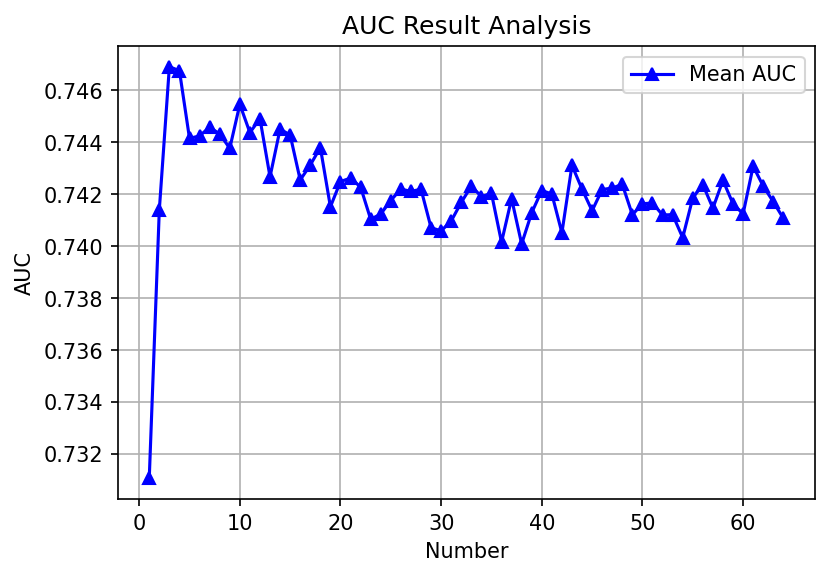

In [76]:
#plot figure
plt.rcParams['savefig.dpi'] = 150 
plt.rcParams['figure.dpi'] = 150 
plt.title('AUC Result Analysis')
plt.plot(number, mean_auc, color='blue', marker='^', label='Mean AUC')
plt.legend()
plt.xlabel('Number')
plt.ylabel('AUC')
plt.grid()
plt.show()

# The top 14 physicochemical properties with the single best performance are selected as the final coding scheme

In [84]:
with open(os.path.join(parent_dir, r'Data\AAindex\Sort_AAindex.txt'),'w') as f:
    f.write('AccNo\t')
    for i in AA:
        f.write(i)
        f.write('\t')
    f.write('\n')
    for j in sort_AAindexName:
        f.write(j)
        f.write('\t')
        for k in AAindex[AAindexName.index(j)]:
            f.write(k)
            f.write('\t')
        f.write('\n')